# Homework 3: Auto diff in numpy

Iterations on a classical theme...

In tutorials we've coded up networks in pytorch, julia... and this is one last exercise!
However, since we have coded up custom pullbacks in julia already, if you'd like to answer the questions in this notebook by submitting a simple julia script instead, we'll also accept that solution!

The goal of this exercise is just to cross check your work from pencil and paper math, to what you code up yourself, to some AD package :)

**Table of Contents**
1. Computational graphs 
2. Build a NN
3. Calc NN gradients
4. Check gradients in pytorch
5. Add a loss ✏️ 

Nicole Hartman

ODSL ML Block Course 

Originally from Apr 2024, last revised Feb 2025


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Computational graphs

**Motivating example:**  Let's code up the model we had worked out in lecture.

$$f(x,y,z) = (x+y) \cdot z$$

<span style="color:red">$$f_1(x,y) = q = x+y$$</span>

<span style="color:blue">$$f_2(q,z) = q \cdot z$$</span>

<img src="../figures/toy-ex.jpg" width=650>

**To Do:** Implement `f1`, `f2` and `f` functions in numpy with both a forward and a backward mode.

In [2]:
def f1(x,y, grad=None):
    '''
    f1(x,y) = x+y
    
    Inputs:
    - x,y: The inputs to the functoin
    - grad: if not None, this is the "upstream gradient"

    Outpus:
    - If (upstream) grad is passed, return f1(x,y), output_grad
    - Else, just the "normal" fct, return f1(x,y)
    '''
    
    out = x+y
    if grad:
        dqdx = 1
        dqdy = 1
        # here grad = df/dq
        dfdx = dqdx * grad
        dfdy = dqdy * grad
        return out, np.array([dfdx, dfdy])
    else:
        return out

In [3]:
def f2(q,z, grad=None):
    '''
    f2(q,z) = q*z
    '''

    out = q * z
    if grad:
       return out, np.array([z,q])*grad
    else: 
        return out

In [4]:
def f(x,y,z, grad=None):
    '''
    f(x,y,z) = f2(q,x)
    '''

    # Need to run the program 1x to get the values to eval the grad
    
    q = f1(x,y)
    out = f2(q,z)
    
    if grad:
        
        _, [dfdq, dfdz] = f2(q,z,grad=grad)
        _, [dfdx,dfdy] = f1(x,y, dfdq)
        
        return out, [dfdx, dfdy, dfdz]
    
    else:
        
        return out

Check the forward mode

In [5]:
x,y,z = 5,-2,4
print(f(x,y,z))

12



**What about the derivative?**

In [6]:
dfdf = 1
out, grad = f(x,y,z, grad=dfdf)

for xi, dfi in zip(['x','y','z'],grad):
    print(f'df/d{xi}= {dfi}')


df/dx= 4
df/dy= 4
df/dz= 3


## Step 2: Multi-layer perceptron (forward pass)

Define a simple feed-forward NN that accepts a input matrix

$$X \in \mathbb{R}^{N \times d}$$

(where for the example just above $N=200$, $d=5$)

and constructs an MLP with a single hidden layer with $H = 16$ units, and a ReLU non-linearity.

**Hint:** this is just three equations:

$$z = X W_1^T + b_1$$


$$h = \mathrm{ReLU}(z_1)$$




$$y_\textrm{pred} =h W_2^T  + b_2$$

where $W_1 \in \mathbb{R}^{H \times d}, b_1 \in \mathbb{R}^{H}, W_2 \in \mathbb{R}^{1 \times H}, b_2 \in \mathbb{R}$,
$z \in \mathbb{R}^{N\times H}$, $h \in \mathbb{R}^{N \times H}$

**Potentially useful functions:** 
- `np.einsum`
- `np.where`
- `np.random.randn`

In [7]:
# We'll just use a random dataset for this problem
n = 128
d = 4
X = np.random.randn(n,d)

In [8]:
# Initialize the parameters (randomly) to have the desired shape
H = 16

'''
TO DO: Initialize the parameters
'''

# 1st layer of the NN
W1 = np.random.randn(H, d)
b1 = np.random.randn(H)

# Now the 2nd layer of the NN
W2 = np.random.randn(1,H)
b2 = np.random.randn(1)

for v in [W1,b1,W2,b2]:
    print(v.shape)


(16, 4)
(16,)
(1, 16)
(1,)


$$ReLU(x) = \max(x,0)$$

In [9]:
def relu(x):
    return np.where(x>0, x, 0)


In [10]:
z = np.array([1,3,-1])
relu(z)

array([1, 3, 0])

In [11]:
# Set up the feedforward model

# z = "W1x + b1"
z = np.einsum('hj,ij->ih',W1,X) + b1
print(z.shape)

h = relu(z)
print(h.shape)
y_pred = np.einsum('oh,ih->io',W2,h) + b2
print(y_pred.shape)

(128, 16)
(128, 16)
(128, 1)


We're thinking about a regression task right now, so no need to have a non-linearity on the last layer.

In [12]:
# Sanity check: Does the output have the dimensionality we expect?
assert y_pred.shape[0] == n

## Step 3: Gradients of a NN

OK, let's re-code our "neural network" up, but this time with the gradient computation so we can do _back prop_. 

In [13]:
def linear(W,X,b, grad=None):
    '''
    Linear layer mapping H = W x + b
    - W: array (m,n)
    - x: array (bs, n)
    - b: array (m)

    Outputs:
    - H: array (bs,m)

    If grad is an array (bs,m), return tuple: out, (grad_W, grad_b, grad_H)
    - grad_W: array (bs, m, n)
    - grad_b: array (bs, m)
    - grad_X: array (bs,    n)
    '''

    assert X.shape[1] == W.shape[1]
    assert W.shape[0] == b.shape[0]

    H = np.einsum('mn,bn->bm',W,X) + b
    
    if grad is not None:
        
        grad_W = np.einsum('bn,bm->bmn',X,grad)
        grad_b = grad * np.ones_like(b)
        grad_X = np.einsum('mn,bm->bn',W,grad)
        
        return H, (grad_W, grad_b, grad_X)
    else:
        return H

In [14]:
def relu(z,grad=None):
    '''
    Non-linearity: better gradient flow
    '''
    out = np.where(z>0,z,0)

    if grad is not None:
        dz = (z>0).astype(float) 
        return out, dz * grad
    else:
        return out

In [15]:
def myNN(X, param_dict, grad=None):
    '''
    Build an MLP with a single hidden layer.
    '''

    # Unpack the parameter dict
    W1, b1 = param_dict["W1"], param_dict["b1"]
    W2, b2 = param_dict["W2"], param_dict["b2"]

    # forward pass
    z = linear(W1,X,b1)
    h = relu(z)
    out = linear(W2,h,b2)

    if grad is not None:
        
        # reverse pass 
        _, (grad_W2, grad_b2, grad_h) = linear(W2,h,b2, grad)
        _, dz = relu(z, grad_h)
        _, (grad_W1, grad_b1, grad_x) = linear (W1,X,b1, dz)

        grad_dict ={'W1':grad_W1.mean(axis=0),
                    'b1':grad_b1.mean(axis=0),
                    'W2':grad_W2.mean(axis=0),
                    'b2':grad_b2.mean(axis=0)}       

        return out.mean(), grad_dict
    else:
        return out.mean()

In [16]:
param_dict ={'W1':W1,'b1':b1,'W2':W2,'b2':b2}

In [17]:
# forward mode
out = myNN(X, param_dict)
out

np.float64(-1.7242484222890089)

In [18]:
# reverse mode
dfdf = np.ones((1,1))
out, grad_dict = myNN(X, param_dict,np.ones((1,1)))
out

np.float64(-1.7242484222890089)

In [19]:
for k in param_dict.keys():
    print(k,grad_dict[k].shape)

W1 (16, 4)
b1 (16,)
W2 (1, 16)
b2 (1,)


## Step 4: Cross check the gradients in jax

`Jax` is an **automatic differentiation** library where it can automatically keep track of the gradient propagation for us instead of us needing to keep track of everything manually with these "forward" and reverse modes.

We'll cover another auto diff library, `pytorch` in more detail tomorrow, but we'll use jax here for x-checking the gradients as it's a very transparent interface for these types of checks.

Also, it's super cute b/c the code stays _almost identical_, just replace `np` with `jnp`, so we can just reuse the forward pass NN code we wrote back in step 1.


In [20]:
import jax
from jax import grad
from jax import numpy as jnp

Illustrative example: Calculate the gradient of :

$$g(x) = x^2, \qquad g'(x) = 2x$$

In [21]:
def g(xi):
    return xi**2

In [22]:
# Set up the gradient function
grad_g = grad(g) # 2x

# To evaluate the gradient, need to eval at a specific point, $x$
grad_g(3.)

Array(6., dtype=float32, weak_type=True)

In [23]:
# Let's evaluate the same parameters... just need to type cast to numpy
param_dict_jax = {k:jnp.array(v) for k,v in param_dict.items()}

In [24]:
def relu_jax(z):
    return jnp.where(z>0,z,0)

In [25]:
def linear_jax(W,X,b):
    '''
    Linear layer mapping H = W x + b
    - W: array (m,n)
    - x: array (bs, n)
    - b: array (m)

    Outputs:
    - H: array (bs,m)
    '''
    
    return jnp.einsum('mn,bn->bm',W,X) + b

In [26]:
# (X, param_dict)
def myNN_jax(param_dict):

    # Unpack the parameters
    W1 = param_dict['W1']
    b1 = param_dict['b1']
    
    W2 = param_dict['W2']
    b2 = param_dict['b2']

    # forward pass
    z1 = linear_jax(W1, X, b1)
    h1 = relu_jax(z1)

    z2 = linear_jax(W2, h1, b2)
    
    return z2.mean()

In [27]:
grad_nn = grad(myNN_jax)

# And... evaluate it!
grad_dict_jax = grad_nn(param_dict_jax)

In [28]:
for k, v in grad_dict_jax.items():
    print(k, v.shape, grad_dict[k].shape)

W1 (16, 4) (16, 4)
W2 (1, 16) (1, 16)
b1 (16,) (16,)
b2 (1,) (1,)


In [29]:
for k, v in grad_dict_jax.items():
    print(k, np.all(np.isclose(v, grad_dict[k])))

W1 True
W2 True
b1 True
b2 True


## Step 5: Connecting to the loss function

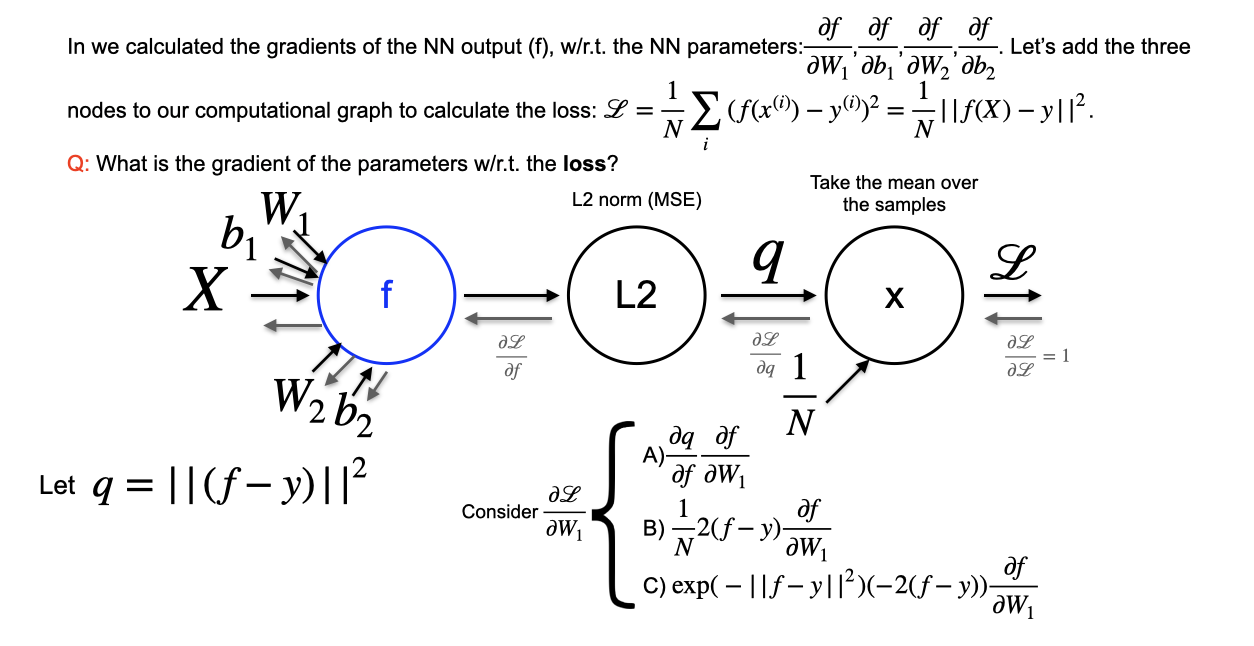

In theory, you can get gradients w/r.t. the full loss next, but this is where we'll stop the required homework, you've done a great job exercising your AD muscles!

Awesome, you've played around with auto diff (AD), coded up both some intro examples and a simple NN, and cross checked these gradients with one of the autodiff packages on the market.

For the rest of the course, we will take advantage of the AD and DL frameworks on the market (notably pytorch), but feel free to use any package you like here!!
